Vanillin production
------------------

In 2010, Brochado *et al* used heuristic optimization together with flux simulations to design a vanillin producing yeast strain.

Brochado, A. R., Andrejev, S., Maranas, C. D., & Patil, K. R. (2012). Impact of stoichiometry representation on simulation of genotype-phenotype relationships in metabolic networks. PLoS Computational Biology, 8(11), e1002758. doi:10.1371/journal.pcbi.1002758

Genome-scale metabolic model
--------------------------

In their work, the authors used *iFF708* model, but recent insights in Yeast yielded newer and more complete versions. The latest version of *S. cerevisiae* model is *Yeast 7.6*. This model constains a higher coverage of gene functions.

Becuase this algorithms should be agnostic to the model, we implement the same strategy with the latest model.


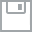
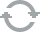
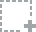
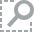
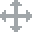
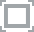
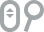
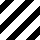
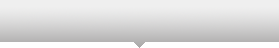
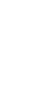
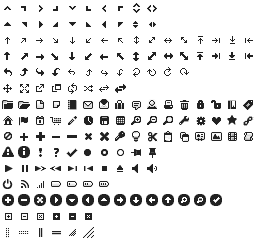
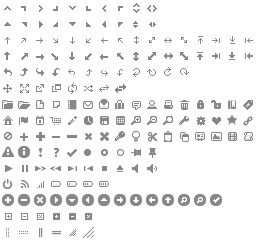
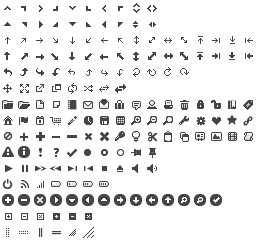
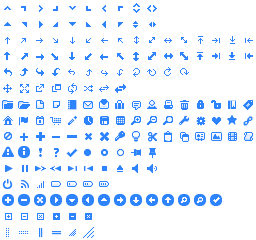
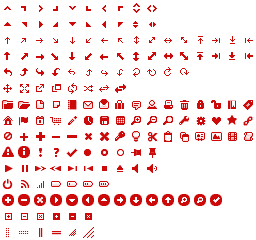
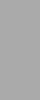
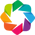
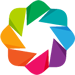

In [1]:
from cameo import models

In [2]:
model = models.minho.yeast_7_6

In [3]:
#Fix gene rules compatibility
for reaction in model.reactions:
    while "AND" in reaction.gene_reaction_rule or "OR" in reaction.gene_reaction_rule:
        reaction.gene_reaction_rule = reaction._gene_reaction_rule.replace("AND", "and").replace("OR", "or")

cobra/io/sbml.py:149 UserWarning: charge of s_0330 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0332 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0334 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0337 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0338 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0339 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0404 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0428 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0429 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0430 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0431 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0432 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0433 is not a number ()
cobra/io/sbml.py:149 UserWarning: charge of s_0450 is not a number ()
cobra/io/sbml.py:149

Constraints can be set in the model according to data found in the literature. The defined conditions allow the simulation of phenotypes very close to the experimental results.

<img src=http://www.biomedcentral.com/content/figures/1752-0509-7-36-2.jpg/>
**Model validation by comparing in silico prediction of the specific growth rate with experimental data**. Growth phenotypes were collected from literature and compared to simulated values for chemostat cultivations at four different conditions, nitrogen limited aerobic (green) and anaerobic (red), carbon limited aerobic (blue) and anaerobic (white).


Österlund, T., Nookaew, I., Bordel, S., & Nielsen, J. (2013). Mapping condition-dependent regulation of metabolism in yeast through genome-scale modeling. BMC Systems Biology, 7, 36. doi:10.1186/1752-0509-7-36

In [4]:
model.reactions.r_1714.lower_bound = -13 #glucose exchange
model.reactions.r_1992.lower_bound = -3  #oxygen exchange

In [5]:
model.medium

reaction_id       reaction_name  lower_bound  upper_bound
0      r_1654   ammonium exchange        -1000         1000
1      r_1714  D-glucose exchange          -13         1000
2      r_1832         H+ exchange        -1000         1000
3      r_1861   iron(2+) exchange        -1000         1000
4      r_1992     oxygen exchange           -3         1000
5      r_2005  phosphate exchange        -1000         1000
6      r_2020  potassium exchange        -1000         1000
7      r_2049     sodium exchange        -1000         1000
8      r_2060   sulphate exchange        -1000         1000
9      r_2100      water exchange        -1000         1000

In [6]:
model.objective = model.reactions.r_2111 #growth
model.optimize().f

0.3925993816536346

Heterologous pathway
-------------------

Vanillin is not produced by *S. cervisiae*. In their work an heterolgous pathway is inserted to allow generate a vanillin production strain. The pathway is described as:

<img src=http://static-content.springer.com/image/art%3A10.1186%2F1475-2859-9-84/MediaObjects/12934_2010_Article_474_Fig1_HTML.jpg>
**Schematic representation of the de novo VG biosynthetic pathway in S. Cerevisisae** (as designed by Hansen et al [5]). Metabolites are shown in black, enzymes are shown in black and in italic, cofactors and additional precursors are shown in red. Reactions catalyzed by heterologously introduced enzymes are shown in red. Reactions converting glucose to aromatic amino acids are represented by dashed black arrows. Metabolite secretion is represented by solid black arrows where relative thickness corresponds to relative extracellular accumulation. 3-DSH stands for 3-dedhydroshikimate, PAC stands for protocathechuic acid, PAL stands for protocatechuic aldehyde, SAM stands for S-adenosylmethionine. 3DSD stands for 3-dedhydroshikimate dehydratase, ACAR stands for aryl carboxylic acid reductase, PPTase stands for phosphopantetheine transferase, hsOMT stands for O-methyltransferase, and UGT stands for UDP-glycosyltransferase. Adapted from Hansen et al. [5].
Brochado et al. Microbial Cell Factories 2010 9:84   doi:10.1186/1475-2859-9-84

Using **cameo**, is very easy to generate a pathway and add it to a model.

In [7]:
from cameo.core.pathway import Pathway

In [8]:
vanillin_pathway = Pathway.from_file("data/vanillin_pathway.tsv")
vanillin_pathway.data_frame

equation  lower_bound  \
3DSD         3-dehydroshikimate --> protocathechuic acid + H2O            0   
ACAR_PPTase  ATP + protocathechuic acid + NADPH --> ADP + N...            0   
hsOMT        protocatechuic aldehyde + S-adenosyl-L-methion...            0   
UGT            UDP-glucose + Vanillin --> vanillin-B-glucoside            0   

             upper_bound  
3DSD                1000  
ACAR_PPTase         1000  
hsOMT               1000  
UGT                 1000

And now we can plug the pathway to the model.

In [9]:
vanillin_pathway.plug_model(model)

In [10]:
from cameo import phenotypic_phase_plane

In [11]:
production_envelope = phenotypic_phase_plane(model, variables=[model.reactions.r_2111], 
                                             objective=model.reactions.EX_vnlBglu)
production_envelope.plot()

To find gene knockout targets, we use `cameo.strain_design.heuristic` package which implements the OptGene strategy.

The authors used the biomass-product coupled yield (bpcy) for optimization which is the equivalent of running OptGene in non-robust mode. All simulations were computed using MOMA but because **cameo** does not implement MOMA we use it's equivalent linear version (it minimizes the absolute distance instead of the quadratic distance). The linear MOMA version is faster than the original MOMA formulation.

In [12]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene
from cameo.flux_analysis.simulation import lmoma

In [ ]:
optgene = OptGene(model)

INFO:cameo.strain_design.heuristic.evolutionary.optimization:No WT reference found, generating using pfba.


Starting optimization at Thu, 14 Jan 2016 15:30:20



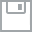
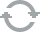
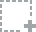
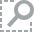
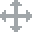
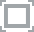
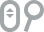
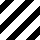
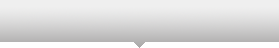
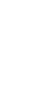
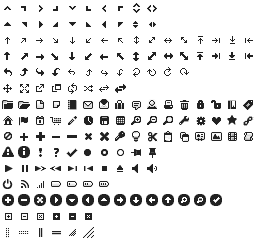
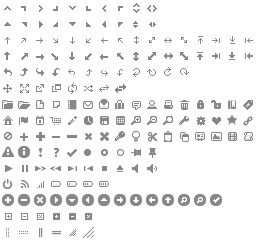
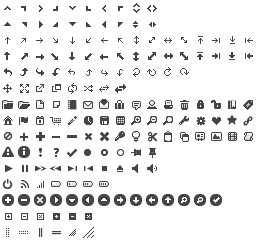
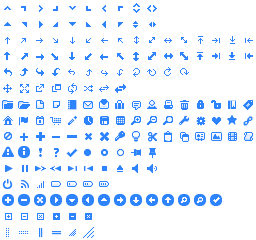
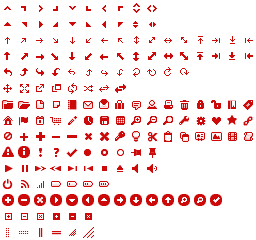
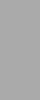
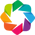
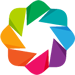

Using saved session configuration for http://localhost:5006/
To override, pass 'load_from_config=False' to Session


/Users/joao/.virtualenvs/cameo-py3/lib/python3.4/site-packages/bokeh/session.py:318 UserWarning: You need to start the bokeh-server to see this example.



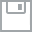
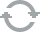
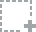
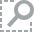
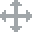
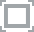
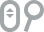
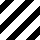
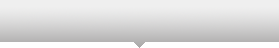
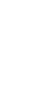
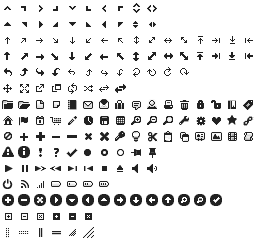
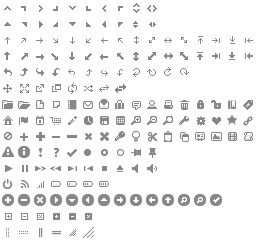
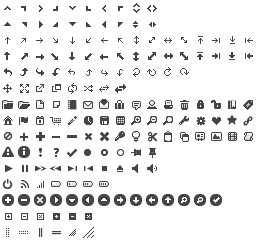
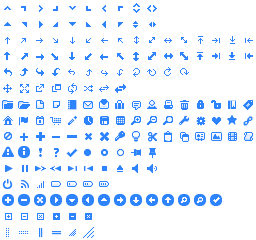
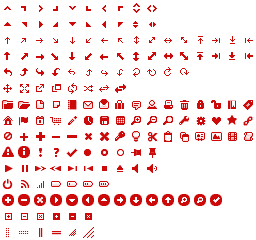
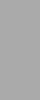
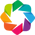
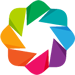

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%prun optgene.run(target="EX_vnlBglu", biomass="r_2111", substrate="r_1714", simulation_method=lmoma, robust=False)